In [1]:
!pip install torchinfo

## Importing the relevant libraries

In [2]:
import torch, warnings, time
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from torchinfo import summary
from torch.nn.utils import clip_grad_norm_

## Loading the Global Equity dataset

In [3]:
df = pd.read_csv('/kaggle/input/global-equity-dataset/Global Equity.csv',index_col='Unnamed: 0',usecols=['Unnamed: 0','close'])
df.head()

,close
1999-11-12,89.19
1999-11-19,86.00
1999-11-26,91.12
1999-12-03,96.12
1999-12-10,93.87


## Data Exploration

In [4]:
df.shape

(1108, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1108 entries, 1999-11-12 to 2021-01-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1108 non-null   float64
dtypes: float64(1)
memory usage: 17.3+ KB


In [6]:
df.index.freq = 'W'

In [7]:
df.index

Index(['1999-11-12', '1999-11-19', '1999-11-26', '1999-12-03', '1999-12-10',
       '1999-12-17', '1999-12-23', '1999-12-31', '2000-01-07', '2000-01-14',
       ...
       '2020-11-27', '2020-12-04', '2020-12-11', '2020-12-18', '2020-12-24',
       '2020-12-31', '2021-01-08', '2021-01-15', '2021-01-22', '2021-01-29'],
      dtype='object', length=1108)

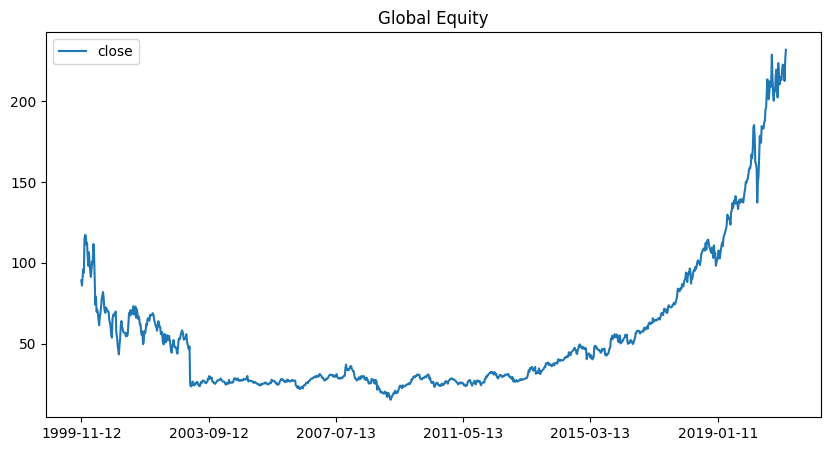

In [8]:
df.plot(figsize=(10,5),title='Global Equity');

In [9]:
df.isna().sum()

close    0
dtype: int64

In [10]:
y = df.close.astype('float').values
y

array([ 89.19,  86.  ,  91.12, ..., 212.65, 225.95, 231.96])

## Dividing data into train and test sets

In [11]:
train_df, test_df = train_test_split(df,test_size=0.8,shuffle=False,random_state=101)

In [12]:
train_df.shape, test_df.shape

((221, 1), (887, 1))

## Feature Scaling

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
train_norm = scaler.fit_transform(train_df)
test_norm = scaler.transform(test_df)

## Creating a custom Time Series Dataset class

In [14]:
class TimeSeriesDataset(Dataset):

    def __init__(self,sequence_data,sequence_length):
        super().__init__()
        self.sequence = torch.tensor(sequence_data,dtype=torch.float32)
        self.sequence_length = sequence_length
        self.num_samples = len(self.sequence) - self.sequence_length

    def __len__(self):
        return self.num_samples

    def __getitem__(self,idx):
        window = self.sequence[idx:idx+self.sequence_length]
        label = self.sequence[idx+self.sequence_length]
        return (window,label)

In [15]:
torch.manual_seed(48)
train_data = TimeSeriesDataset(train_norm,sequence_length=10)
test_data = TimeSeriesDataset(test_norm,sequence_length=10)

## Creating Data Loaders for train and test sets

In [16]:
train_data_loader = DataLoader(dataset=train_data,batch_size=10,shuffle=False,num_workers=5)
test_data_loader = DataLoader(dataset=test_data,batch_size=10,shuffle=False,num_workers=5)

In [17]:
for seq, targets in train_data_loader:
    break

In [18]:
seq[0], targets[0]

(tensor([[0.6991],
         [0.6651],
         [0.7196],
         [0.7729],
         [0.7489],
         [0.9767],
         [1.0000],
         [0.9927],
         [0.9361],
         [0.9447]]),
 tensor([0.8542]))

## Defining the LSTM model architecture

In [19]:
class LSTM(nn.Module):

    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size,out_features=output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))

    def forward(self,sequence):
        batch_size = sequence.size(0)
        self.hidden = self.init_hidden(batch_size)
        lstm_output, self.hidden = self.lstm(sequence,self.hidden)
        pred = self.linear(lstm_output[:,-1,:])
        return pred

    def init_hidden(self,batch_size):
        return (torch.zeros(1,batch_size,self.hidden_size),torch.zeros(1,batch_size,self.hidden_size))

In [20]:
torch.manual_seed(48)
model = LSTM(input_size=1,hidden_size=150)
model

LSTM(
  (lstm): LSTM(1, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [21]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()

print("Total LSTM model parameters:", total_params)

600
90000
600
600
150
1
Total LSTM model parameters: 91951


In [22]:
summary(model)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              91,800
├─Linear: 1-2                            151
Total params: 91,951
Trainable params: 91,951
Non-trainable params: 0

## Model Training & Evaluation

In [23]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(params=model.parameters(),lr=0.001)

In [24]:
epochs = 100

losses = []

start_time = time.time()

for i in range(1,epochs+1):
    epoch_loss = 0
    
    for seq, y_train in train_data_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss/len(train_data_loader))
    print(f"Epoch {i} -> Loss: {epoch_loss/len(train_data_loader)}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.12628515149382027
Epoch 2 -> Loss: 0.049639066242062574
Epoch 3 -> Loss: 0.0261874936404638
Epoch 4 -> Loss: 0.030551062992096624
Epoch 5 -> Loss: 0.013637871285688809
Epoch 6 -> Loss: 0.009970689048879483
Epoch 7 -> Loss: 0.008055377230696402
Epoch 8 -> Loss: 0.008130337411304563
Epoch 9 -> Loss: 0.00929417505937057
Epoch 10 -> Loss: 0.01145900699669834
Epoch 11 -> Loss: 0.01193891677857292
Epoch 12 -> Loss: 0.008197609237289395
Epoch 13 -> Loss: 0.0058824574088331165
Epoch 14 -> Loss: 0.005750031329377883
Epoch 15 -> Loss: 0.005090709622229703
Epoch 16 -> Loss: 0.004873372044874652
Epoch 17 -> Loss: 0.004844319040950557
Epoch 18 -> Loss: 0.004875419655780372
Epoch 19 -> Loss: 0.004935325368767901
Epoch 20 -> Loss: 0.005010934809185776
Epoch 21 -> Loss: 0.005020977152691392
Epoch 22 -> Loss: 0.005103643474616216
Epoch 23 -> Loss: 0.004988278104891916
Epoch 24 -> Loss: 0.004961107628001959
Epoch 25 -> Loss: 0.0047461767231156545
Epoch 26 -> Loss: 0.00465300165425023


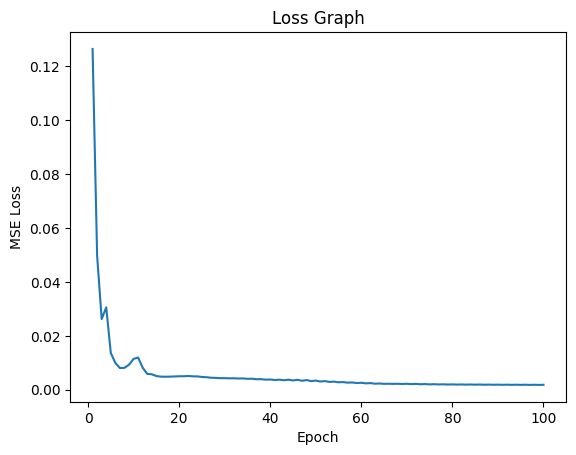

In [25]:
plt.plot(range(1,epochs+1),losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Graph')
plt.show();

In [26]:
model.eval() # Set model to evaluation mode
test_loss = 0
all_predictions = []
all_targets = []

with torch.no_grad():

    for seq, y_test in test_data_loader:
        y_pred = model(seq)
        loss = criterion(y_pred,y_test)
        test_loss += loss.item()
        all_predictions.append(y_pred)
        all_targets.append(y_test)

test_loss /= len(test_data_loader)
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)
print("Average test loss:", round(test_loss,4))

Average test loss: 0.0023


In [27]:
all_predictions[:5]

array([[0.0175969 ],
       [0.01472273],
       [0.02951889],
       [0.02670479],
       [0.0207421 ]], dtype=float32)

In [28]:
all_targets[:5]

array([[0.01704303],
       [0.04239454],
       [0.02737537],
       [0.02364721],
       [0.02449936]], dtype=float32)

In [29]:
true_predictions = scaler.inverse_transform(all_predictions.reshape(-1,1))
true_predictions[:5]

array([[25.211998],
       [24.942171],
       [26.331232],
       [26.067047],
       [25.507269]], dtype=float32)

In [30]:
actual_values = scaler.inverse_transform(all_targets.reshape(-1,1))
actual_values[:5]

array([[25.16    ],
       [27.54    ],
       [26.130001],
       [25.779999],
       [25.86    ]], dtype=float32)

In [31]:
print("MAE:", mean_absolute_error(actual_values,true_predictions))
print("MSE:", mean_squared_error(actual_values,true_predictions))
print("MAPE:", mean_absolute_percentage_error(actual_values,true_predictions))
print("MSLE:", mean_squared_log_error(actual_values,true_predictions))
print("RMSE:", np.sqrt(mean_squared_error(actual_values,true_predictions)))

MAE: 2.529215
MSE: 19.216318
MAPE: 0.03847716
MSLE: 0.0021951494
RMSE: 4.383642


In [32]:
test_df.index

Index(['2004-02-06', '2004-02-13', '2004-02-20', '2004-02-27', '2004-03-05',
       '2004-03-12', '2004-03-19', '2004-03-26', '2004-04-02', '2004-04-08',
       ...
       '2020-11-27', '2020-12-04', '2020-12-11', '2020-12-18', '2020-12-24',
       '2020-12-31', '2021-01-08', '2021-01-15', '2021-01-22', '2021-01-29'],
      dtype='object', length=887)

In [33]:
dates = pd.date_range(start='2004-02-06',end='2021-01-29',freq='W')
dates = dates[:len(true_predictions)]
dates

DatetimeIndex(['2004-02-08', '2004-02-15', '2004-02-22', '2004-02-29',
               '2004-03-07', '2004-03-14', '2004-03-21', '2004-03-28',
               '2004-04-04', '2004-04-11',
               ...
               '2020-09-20', '2020-09-27', '2020-10-04', '2020-10-11',
               '2020-10-18', '2020-10-25', '2020-11-01', '2020-11-08',
               '2020-11-15', '2020-11-22'],
              dtype='datetime64[ns]', length=877, freq='W-SUN')

In [34]:
true_predictions = true_predictions.flatten()
actual_values = actual_values.flatten()

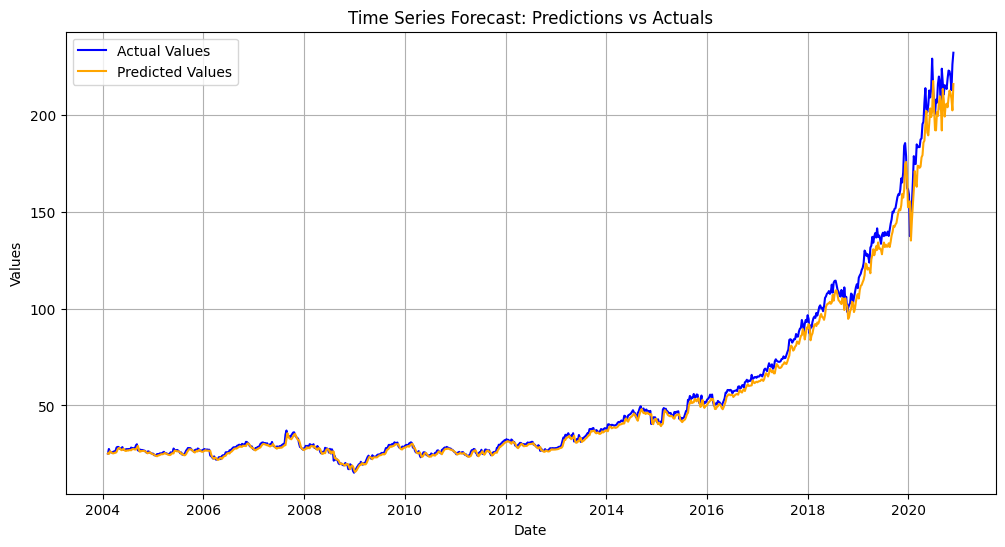

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_values, label='Actual Values', color='blue')
plt.plot(dates, true_predictions, label='Predicted Values', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Forecast: Predictions vs Actuals')
plt.legend()
plt.grid(True)
plt.show()

## Re-training the model on whole data

In [36]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Reduce LR every 20 epochs

In [37]:
# Custom function to initialize model weights using Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

In [38]:
model.apply(init_weights)

LSTM(
  (lstm): LSTM(1, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [39]:
epochs = 100

y_norm = scaler.transform(y.reshape(-1,1))
all_data = TimeSeriesDataset(sequence_data=y_norm,sequence_length=10)
all_data_loader = DataLoader(dataset=all_data,batch_size=10,shuffle=False,num_workers=5)

model.train()

losses = []

start_time = time.time()

for i in range(1,epochs+1):

    epoch_loss = 0
    
    for seq, y_train in all_data_loader:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        clip_grad_norm_(parameters=model.parameters(),max_norm=1.0) # Gradient clipping
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(all_data_loader)
    scheduler.step() # Adjust learning rate
    losses.append(epoch_loss)
    print(f"Epoch {i} -> Loss: {epoch_loss}")

print(f"Total time elapsed in LSTM model retraining: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.14320059157828588
Epoch 2 -> Loss: 0.024865446476509203
Epoch 3 -> Loss: 0.012555189360930606
Epoch 4 -> Loss: 0.00835224178147407
Epoch 5 -> Loss: 0.006896023116364218
Epoch 6 -> Loss: 0.005825404424066702
Epoch 7 -> Loss: 0.005248936396434477
Epoch 8 -> Loss: 0.004714659325294302
Epoch 9 -> Loss: 0.0041182180491060455
Epoch 10 -> Loss: 0.0037288215434686705
Epoch 11 -> Loss: 0.003527568988482182
Epoch 12 -> Loss: 0.003432557858600789
Epoch 13 -> Loss: 0.003410417248067626
Epoch 14 -> Loss: 0.0034393720503761538
Epoch 15 -> Loss: 0.0035021052318453174
Epoch 16 -> Loss: 0.003582643120766575
Epoch 17 -> Loss: 0.0036655978435605487
Epoch 18 -> Loss: 0.003737301629239069
Epoch 19 -> Loss: 0.0037816078392180234
Epoch 20 -> Loss: 0.0037960958891000533
Epoch 21 -> Loss: 0.004239339556848294
Epoch 22 -> Loss: 0.0028717298027913785
Epoch 23 -> Loss: 0.0022136015171285678
Epoch 24 -> Loss: 0.002269674526236155
Epoch 25 -> Loss: 0.0022850349592111094
Epoch 26 -> Loss: 0.002301

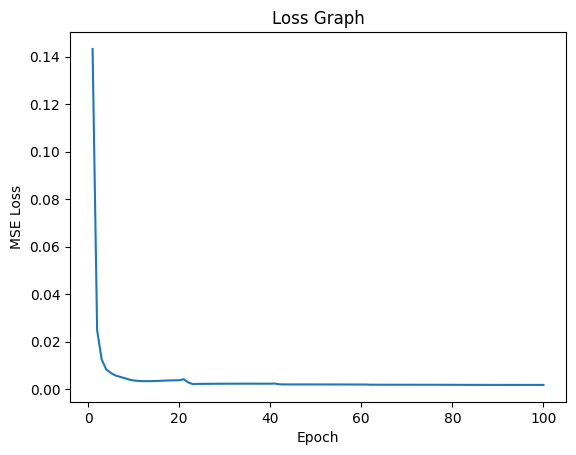

In [40]:
plt.plot(range(1,epochs+1),losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Graph')
plt.show();

## Forecasting into unknown future

In [41]:
forecast_horizon = 120
sequence_length = 20
predictions = y_norm[-sequence_length:].flatten().tolist()

model.eval()

for i in range(forecast_horizon):
    sequence = torch.FloatTensor(predictions[-sequence_length:]).view(1, sequence_length, 1)

    with torch.no_grad():
        predictions.append(model(sequence).item())

In [42]:
len(predictions)

140

In [43]:
predictions[-sequence_length:][:5]

[2.76037859916687,
 2.7605721950531006,
 2.760755777359009,
 2.7609293460845947,
 2.7610933780670166]

In [44]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions[:5]

array([[200.39],
       [207.82],
       [206.19],
       [215.81],
       [219.66]])

In [45]:
actual_values = scaler.inverse_transform(np.array(y_norm).reshape(-1,1))
actual_values[:5]

array([[89.19],
       [86.  ],
       [91.12],
       [96.12],
       [93.87]])

In [46]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['1999-11-12', '1999-11-19', '1999-11-26', '1999-12-03',
               '1999-12-10', '1999-12-17', '1999-12-23', '1999-12-31',
               '2000-01-07', '2000-01-14',
               ...
               '2020-11-27', '2020-12-04', '2020-12-11', '2020-12-18',
               '2020-12-24', '2020-12-31', '2021-01-08', '2021-01-15',
               '2021-01-22', '2021-01-29'],
              dtype='datetime64[ns]', length=1108, freq=None)

In [47]:
future_dates = pd.date_range(start=df.index[-1]+pd.Timedelta(weeks=1),
                             periods=forecast_horizon,
                             freq='W')
future_dates

DatetimeIndex(['2021-02-07', '2021-02-14', '2021-02-21', '2021-02-28',
               '2021-03-07', '2021-03-14', '2021-03-21', '2021-03-28',
               '2021-04-04', '2021-04-11',
               ...
               '2023-03-19', '2023-03-26', '2023-04-02', '2023-04-09',
               '2023-04-16', '2023-04-23', '2023-04-30', '2023-05-07',
               '2023-05-14', '2023-05-21'],
              dtype='datetime64[ns]', length=120, freq='W-SUN')

In [48]:
len(future_dates), len(true_predictions[sequence_length:])

(120, 120)

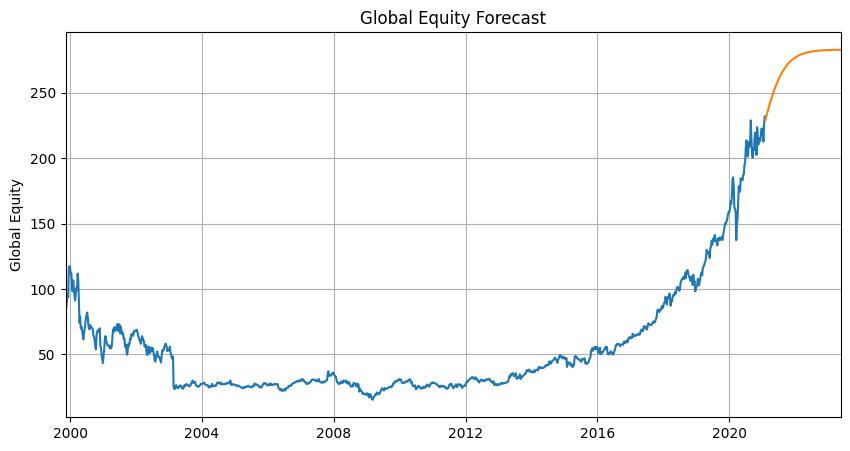

In [49]:
fig = plt.figure(figsize=(10,5))
plt.title('Global Equity Forecast')
plt.ylabel('Global Equity')
plt.grid(visible=True)
plt.autoscale(enable=True,axis='x',tight=True)
plt.plot(df.index,actual_values)
plt.plot(future_dates,true_predictions[sequence_length:])
plt.show();

## Saving the model for future use

In [50]:
torch.save(model,'global_equity_forecaster.pt')

This is a relatively decent forecast considering the simplicity of the LSTM model. Please upvote my notebook if you really liked my work. In case you have any suggestions regarding my work, you can let me know through the comments section below.